# Analysis for SSFA project: NewEplsar model

## Table of contents
1. [Used packages](#imports)
1. [Global settings](#settings)
1. [Load data](#load)
1. [Explore data](#exp)
1. [Model specification](#model)
1. [Inference](#inference)
   1. [NewEplsar](#NewEplsar) 
1. [Summary](#summary)  

## Used packages <a name="imports"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pickle
import arviz as az
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from matplotlib.colors import to_rgb

In [3]:
import scipy.stats as stats 

In [4]:
from IPython.display import display

In [5]:
import matplotlib as mpl

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import plotting_lib

## Global settings <a name="settings"></a>

#### Output

In [8]:
writeOut = True
outPathPlots = "../plots/statistical_model_neweplsar/"
outPathData = "../derived_data/statistical_model_neweplsar/"

#### Plotting

In [9]:
widthMM = 190 
widthInch = widthMM / 25.4
ratio = 0.66666
heigthInch = ratio*widthInch

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style("ticks")

dpi = 300

In [10]:
sizes = [SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE]

#### Computing

In [11]:
numSamples = 500
numCores = 10
numTune = 1000
numPredSamples = 2000
random_seed=3651456135

## Load data <a name="load"></a>

In [12]:
datafile = "../derived_data/preprocessing/preprocessed.dat"

In [13]:
with open(datafile, "rb") as f:
    x1,x2,_,df,dataZ,dictMeanStd,dictTreatment,dictSoftware = pickle.load(f)    

Show that everything is correct:

In [14]:
display(pd.DataFrame.from_dict({'x1':x1,'x2':x2}))

x1  x2
0     0   5
1     1   5
2     0   5
3     1   5
4     0   5
..   ..  ..
275   1   9
276   0   9
277   1   9
278   0   9
279   1   9

[280 rows x 2 columns]

x1 indicates the software used, x2 indicates the treatment applied.

In [15]:
for surfaceParam,(mean,std) in dictMeanStd.items():
    print("Surface parameter {} has mean {} and standard deviation {}".format(surfaceParam,mean,std))

Surface parameter epLsar has mean 0.0028221512571428575 and standard deviation 0.0019000504797019124
Surface parameter R² has mean 0.998765273042857 and standard deviation 0.0015328558023807836
Surface parameter Asfc has mean 18.13129049385357 and standard deviation 16.348381888991312
Surface parameter Smfc has mean 4.938492967075 and standard deviation 38.106353908569346
Surface parameter HAsfc9 has mean 0.3085220006979256 and standard deviation 0.2211140516395699
Surface parameter HAsfc81 has mean 0.5639598041398011 and standard deviation 0.40668126467296095


In [16]:
for k,v in dictTreatment.items():
    print("Number {} encodes treatment {}".format(k,v))

Number 5 encodes treatment Dry Bamboo
Number 6 encodes treatment Dry Grass
Number 7 encodes treatment Dry Lucerne
Number 0 encodes treatment BrushDirt
Number 1 encodes treatment BrushNoDirt
Number 4 encodes treatment Control
Number 10 encodes treatment RubDirt
Number 2 encodes treatment Clover
Number 3 encodes treatment Clover+Dust
Number 8 encodes treatment Grass
Number 9 encodes treatment Grass+Dust


In [17]:
for k,v in dictSoftware.items():
    print("Number {} encodes software {}".format(k,v))

Number 0 encodes software ConfoMap
Number 1 encodes software Toothfrax


In [18]:
display(dataZ)

index  TreatmentNumber  SoftwareNumber  DatasetNumber  NameNumber  \
0        0                5               0              0         116   
1        1                5               1              0         116   
2        2                5               0              0         117   
3        3                5               1              0         117   
4        4                5               0              0         118   
..     ...              ...             ...            ...         ...   
275    275                9               1              2          51   
276    276                9               0              2          52   
277    277                9               1              2          52   
278    278                9               0              2          53   
279    279                9               1              2          53   

     epLsar_z      R²_z    Asfc_z    Smfc_z  HAsfc9_z  HAsfc81_z  
0    0.839414 -0.017104 -0.448128 -0.120476 -0.806963  -0.512247  
1    0.999368  0.518462 -0.477757 -0.126469 -0.782634  -0.497016  
2    1.601888 -0.509024 -0.276513 -0.119325 -0.584158  -0.662886  
3    1.596720  0.457791 -0.301685 -0.126469 -0.629947  -0.744422  
4    1.168099 -0.221668 -0.393502 -0.121498 -0.269712  -0.370958  
..        ...       ...       ...       ...       ...        ...  
275  0.843056  0.387986 -0.997743 -0.092631  2.388080   1.346868  
276  0.305544 -0.791837 -0.967607 -0.104937  2.014963   2.573677  
277  0.166758  0.635237 -0.940337 -0.126098  2.926894   3.117333  
278 -0.843412  0.042974 -1.022523 -0.085082  0.280534   0.543577  
279 -1.115313  0.712218 -1.021455 -0.118879  0.169999   0.678630  

[280 rows x 11 columns]

In [19]:
display(df)

Dataset                            Name   Software        Diet  \
0    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_1   ConfoMap  Dry Bamboo   
1    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_1  Toothfrax  Dry Bamboo   
2    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_2   ConfoMap  Dry Bamboo   
3    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_2  Toothfrax  Dry Bamboo   
4    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_3   ConfoMap  Dry Bamboo   
..          ...                             ...        ...         ...   
275      Sheeps          L8-Ovis-90730-lm2sin-a  Toothfrax  Grass+Dust   
276      Sheeps          L8-Ovis-90764-lm2sin-a   ConfoMap  Grass+Dust   
277      Sheeps          L8-Ovis-90764-lm2sin-a  Toothfrax  Grass+Dust   
278      Sheeps          L8-Ovis-90814-lm2sin-a   ConfoMap  Grass+Dust   
279      Sheeps          L8-Ovis-90814-lm2sin-a  Toothfrax  Grass+Dust   

      Treatment Before.after    epLsar        R²       Asfc      Smfc  \
0    Dry Bamboo          NaN  0.004417  0.998739  10.805118  0.347586   
1    Dry Bamboo          NaN  0.004721  0.999560  10.320730  0.119219   
2    Dry Bamboo          NaN  0.005866  0.997985  13.610750  0.391436   
3    Dry Bamboo          NaN  0.005856  0.999467  13.199232  0.119219   
4    Dry Bamboo          NaN  0.005042  0.998425  11.698166  0.308648   
..          ...          ...       ...       ...        ...       ...   
275  Grass+Dust          NaN  0.004424  0.999360   1.819802  1.408678   
276  Grass+Dust          NaN  0.003403  0.997552   2.312486  0.939718   
277  Grass+Dust          NaN  0.003139  0.999739   2.758297  0.133366   
278  Grass+Dust          NaN  0.001220  0.998831   1.414701  1.696316   
279  Grass+Dust          NaN  0.000703  0.999857   1.432148  0.408433   

       HAsfc9   HAsfc81  NewEplsar  TreatmentNumber  SoftwareNumber  \
0    0.130091  0.355639   0.019460                5               0   
1    0.135471  0.361833        NaN                5               1   
2    0.179356  0.294377   0.020079                5               0   
3    0.169232  0.261217        NaN                5               1   
4    0.248885  0.413098   0.019722                5               0   
..        ...       ...        ...              ...             ...   
275  0.836560  1.111706        NaN                9               1   
276  0.754059  1.610626   0.018978                9               0   
277  0.955699  1.831721        NaN                9               1   
278  0.370552  0.785022   0.017498                9               0   
279  0.346111  0.839946        NaN                9               1   

     DatasetNumber  NameNumber  
0                0         116  
1                0         116  
2                0         117  
3                0         117  
4                0         118  
..             ...         ...  
275              2          51  
276              2          52  
277              2          52  
278              2          53  
279              2          53  

[280 rows x 17 columns]

## Exploration <a name="exp"></a>

In [20]:
dfNewAvail = df[~df.NewEplsar.isna()].copy()

We look at the overall relationship between both epLsar variants on ConfoMap. 

In [21]:
yrange = [0.015,0.022]
xrange = [ -0.0005 , 0.0085]

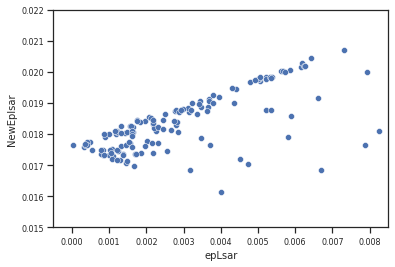

In [22]:
ax = sns.scatterplot(data=dfNewAvail,x='epLsar',y='NewEplsar');
ax.set_xlim(xrange);
ax.set_ylim(yrange);

Could be linear, but there is also a lot of noise.

Maybe different treatments have different behavior?

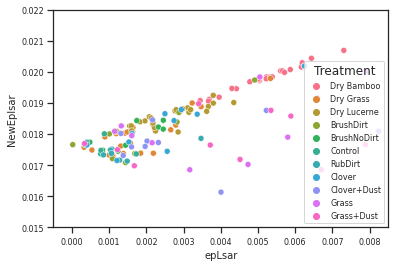

In [23]:
ax = sns.scatterplot(data=dfNewAvail,x='epLsar',y='NewEplsar',hue="Treatment");
ax.set_xlim(xrange);
ax.set_ylim(yrange);

Too crowded, let's try it per dataset

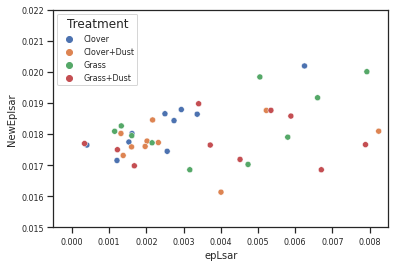

In [24]:
ax = sns.scatterplot(data=dfNewAvail[dfNewAvail.Dataset == "Sheeps"],x='epLsar',y='NewEplsar',hue="Treatment");
ax.set_xlim(xrange);
ax.set_ylim(yrange);

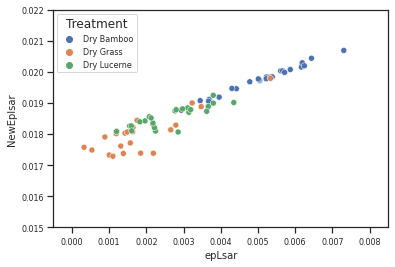

In [25]:
ax = sns.scatterplot(data=dfNewAvail[dfNewAvail.Dataset == "GuineaPigs"],x='epLsar',y='NewEplsar',hue="Treatment");
ax.set_xlim(xrange);
ax.set_ylim(yrange);

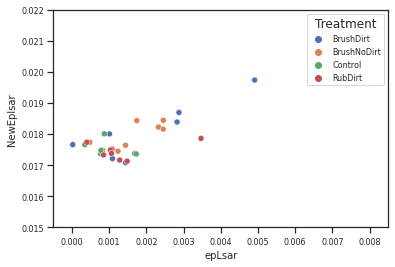

In [26]:
ax = sns.scatterplot(data=dfNewAvail[dfNewAvail.Dataset == "Lithics"],x='epLsar',y='NewEplsar',hue="Treatment");
ax.set_xlim(xrange);
ax.set_ylim(yrange);

### Standardization in z scores

In [27]:
dfNewAvail.NewEplsar

0      0.019460
2      0.020079
4      0.019722
6      0.020694
8      0.019841
         ...   
270    0.018765
272    0.018581
274    0.017697
276    0.018978
278    0.017498
Name: NewEplsar, Length: 140, dtype: float64

In [28]:
mu = dfNewAvail.NewEplsar.mean()
mu

0.018350751528571425

In [29]:
sig = dfNewAvail.NewEplsar.std()
sig

0.0009354858792128117

In [30]:
dictMeanStd['NewEplsar'] = (mu,sig)

In [31]:
newZ = (dfNewAvail.NewEplsar.values-mu) / sig

In [32]:
newIndex = df[~df.NewEplsar.isna()].index.values

## Model specification <a name="model"></a>

In [33]:
class Model_NewEplsar(pm.Model):
    
    """
    Compute params of priors and hyperpriors.
    """
    def getParams(self,x2,y):
        # get lengths        
        Nx2Lvl = np.unique(x2).size
        
        dims = (Nx2Lvl)
        
        ### get standard deviations
        
        # convert to pandas dataframe to use their logic
        df = pd.DataFrame.from_dict({'x2':x2,'y':y})
        
        s2 = df.groupby('x2').std()['y'].max()
        stdSingle = s2
        
        return (dims, stdSingle)
    
    def printParams(self,x2,y):
        dims, stdSingle= self.getParams(x2,y)
        Nx2Lvl = dims
        s2 = stdSingle
                
        print("The number of levels of the x variables are {}".format(dims))
        print("The standard deviations used for the beta prior is {}".format(stdSingle))        
    
    def __init__(self,name,x2,y,model=None):
        
        # call super's init first, passing model and name
        super().__init__(name, model)
        
        # get parameter of hyperpriors
        dims, stdSingle = self.getParams(x2,y)
        Nx2Lvl  = dims
        s2 = stdSingle
                
        ### hyperpriors ### 
        # observation hyperpriors
        lamY = 1/30.
        muGamma = 0.5
        sigmaGamma = 2.
        
        # prediction hyperpriors
        sigma0 = pm.HalfNormal('sigma0',sd=1)         
        sigma2 = pm.HalfNormal('sigma2',sd=s2, shape=Nx2Lvl)
        
        
        mu_b0 = pm.Normal('mu_b0', mu=0., sd=1)              
        mu_b2 = pm.Normal('mu_b2', mu=0., sd=1, shape=Nx2Lvl)       
        beta2 = 1.5*(np.sqrt(6)*sigma2)/(np.pi)
                                       
        ### priors ### 
        # observation priors        
        nuY = pm.Exponential('nuY',lam=lamY)
        sigmaY = pm.Gamma('sigmaY',mu=muGamma, sigma=sigmaGamma)
        
        # prediction priors
        b0_dist = pm.Normal('b0_dist', mu=0, sd=1)
        b0 = pm.Deterministic("b0", mu_b0 + b0_dist * sigma0)
                        
        b2_beta = pm.HalfNormal('b2_beta', sd=beta2, shape=Nx2Lvl)
        b2_dist = pm.Gumbel('b2_dist', mu=0, beta=1)
        b2 = pm.Deterministic("b2", mu_b2 + b2_beta * b2_dist)
        
        #### prediction ###         
        mu = pm.Deterministic('mu',b0 + b2[x2])
                                        
        ### observation ### 
        y = pm.StudentT('y',nu = nuY, mu=mu, sd=sigmaY, observed=y)

## Inference <a name="inference"></a>

### NewEplsar <a name="NewEplsar"></a>

In [34]:
with pm.Model() as model:
    new_epLsarModel = Model_NewEplsar('NewEplsar',x2[newIndex],newZ)

#### Verify model settings

In [35]:
new_epLsarModel.printParams(x2[newIndex],newZ)

The number of levels of the x variables are 11
The standard deviations used for the beta prior is 1.1510253614970998


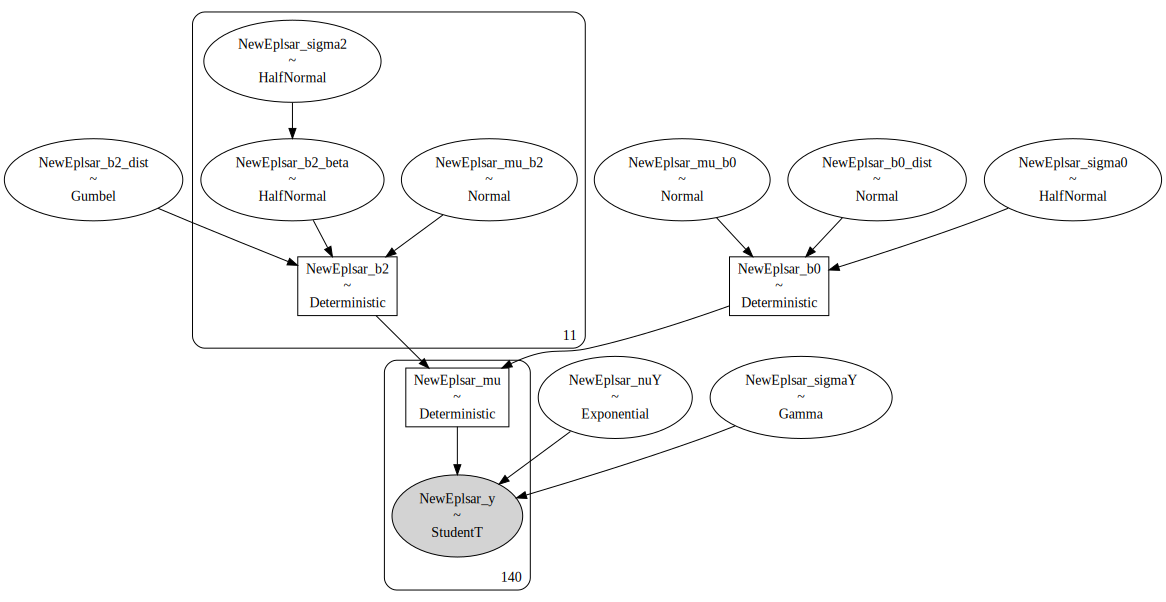

In [36]:
try:
    graph_new_epLsar = pm.model_to_graphviz(new_epLsarModel)    
except:
    graph_new_epLsar = "Could not make graph"
graph_new_epLsar

#### Check prior choice

In [37]:
with new_epLsarModel as model:
    prior_pred_new_epLsar = pm.sample_prior_predictive(samples=numPredSamples,random_seed=random_seed)

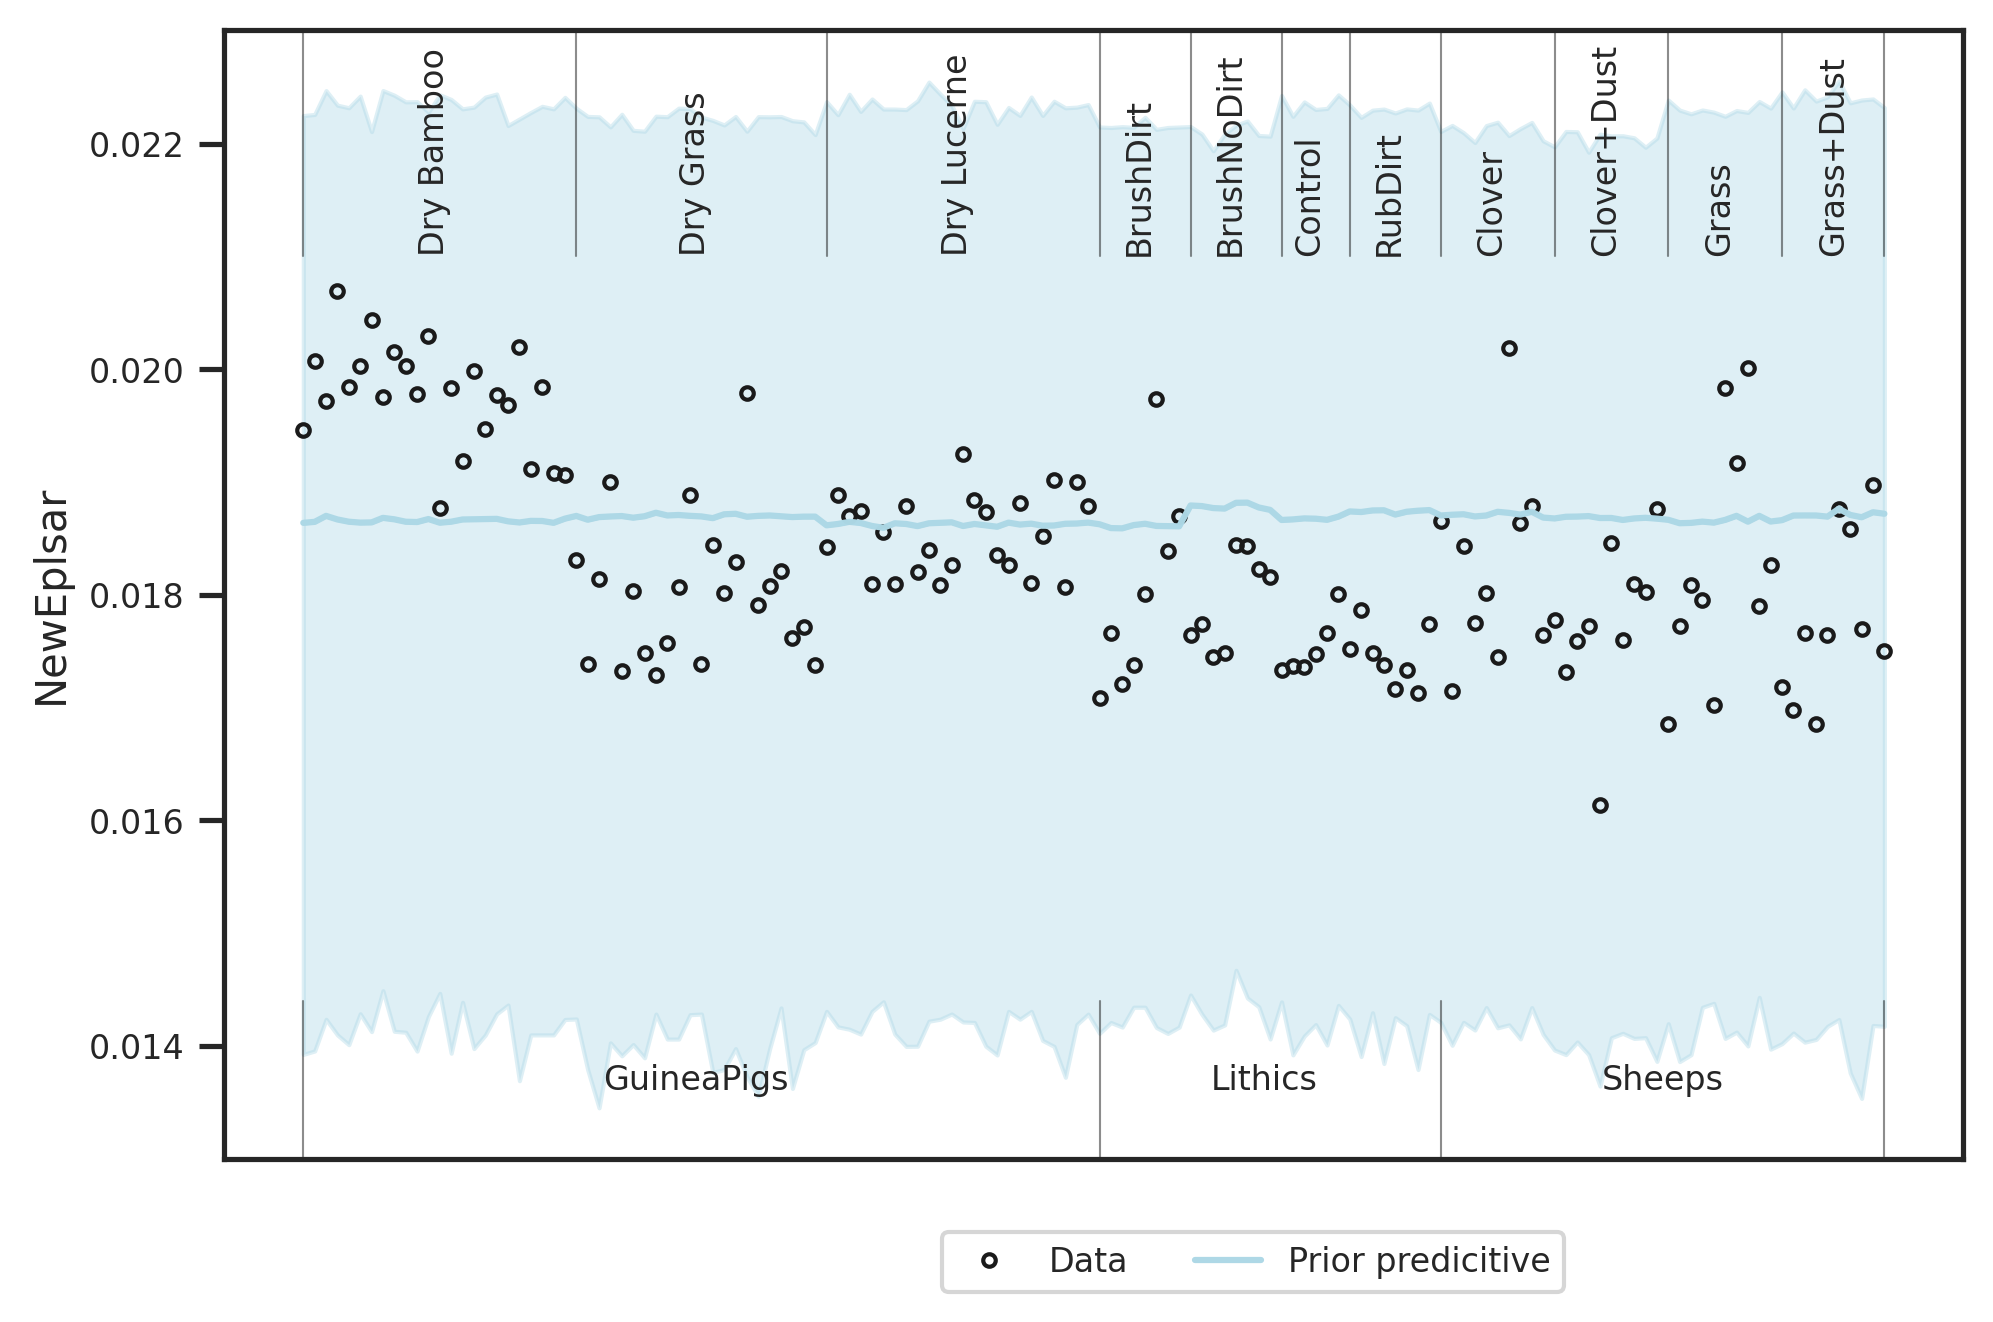

In [38]:
plotting_lib.plotPriorPredictive(widthInch,heigthInch,dpi,writeOut,outPathPlots,dfNewAvail.reset_index(),dictMeanStd,prior_pred_new_epLsar,newZ,'NewEplsar')

Prior choice is as intended: Broad over the data range.

#### Sampling

In [39]:
with new_epLsarModel as model:
    trace_new_epLsar = pm.sample(numSamples,cores=numCores,tune=numTune,max_treedepth=20, init='auto',target_accept=0.99,random_seed=random_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [NewEplsar_b2_dist, NewEplsar_b2_beta, NewEplsar_b0_dist, NewEplsar_sigmaY, NewEplsar_nuY, NewEplsar_mu_b2, NewEplsar_mu_b0, NewEplsar_sigma2, NewEplsar_sigma0]


Sampling 10 chains for 1_000 tune and 500 draw iterations (10_000 + 5_000 draws total) took 106 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [40]:
with new_epLsarModel as model:
    if writeOut:
        with open(outPathData + 'model_{}.pkl'.format('NewEplsar'), 'wb') as buff:
            pickle.dump({'model':new_epLsarModel, 'trace': trace_new_epLsar}, buff)

#### Check sampling

In [41]:
with new_epLsarModel as model:
    dataTrace_new_epLsar = az.from_pymc3(trace=trace_new_epLsar)

In [42]:
pm.summary(dataTrace_new_epLsar,hdi_prob=0.95).round(2)

mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
NewEplsar_mu_b0    -0.21  0.63     -1.42       1.05       0.01     0.01   
NewEplsar_mu_b2[0] -0.18  0.48     -1.12       0.72       0.01     0.01   
NewEplsar_mu_b2[1] -0.13  0.44     -1.02       0.72       0.01     0.01   
NewEplsar_mu_b2[2]  0.07  0.47     -0.83       0.96       0.01     0.01   
NewEplsar_mu_b2[3] -0.29  0.46     -1.16       0.61       0.01     0.01   
...                  ...   ...       ...        ...        ...      ...   
NewEplsar_mu[135]  -0.67  0.22     -1.09      -0.24       0.00     0.00   
NewEplsar_mu[136]  -0.67  0.22     -1.09      -0.24       0.00     0.00   
NewEplsar_mu[137]  -0.67  0.22     -1.09      -0.24       0.00     0.00   
NewEplsar_mu[138]  -0.67  0.22     -1.09      -0.24       0.00     0.00   
NewEplsar_mu[139]  -0.67  0.22     -1.09      -0.24       0.00     0.00   

                    ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
NewEplsar_mu_b0       1973.0  1973.0    1943.0    2814.0    1.0  
NewEplsar_mu_b2[0]    2369.0  2369.0    2375.0    2973.0    1.0  
NewEplsar_mu_b2[1]    2180.0  2180.0    2126.0    3004.0    1.0  
NewEplsar_mu_b2[2]    2384.0  1978.0    2410.0    2600.0    1.0  
NewEplsar_mu_b2[3]    2076.0  2022.0    2083.0    2874.0    1.0  
...                      ...     ...       ...       ...    ...  
NewEplsar_mu[135]     5740.0  5636.0    5753.0    4350.0    1.0  
NewEplsar_mu[136]     5740.0  5636.0    5753.0    4350.0    1.0  
NewEplsar_mu[137]     5740.0  5636.0    5753.0    4350.0    1.0  
NewEplsar_mu[138]     5740.0  5636.0    5753.0    4350.0    1.0  
NewEplsar_mu[139]     5740.0  5636.0    5753.0    4350.0    1.0  

[191 rows x 11 columns]

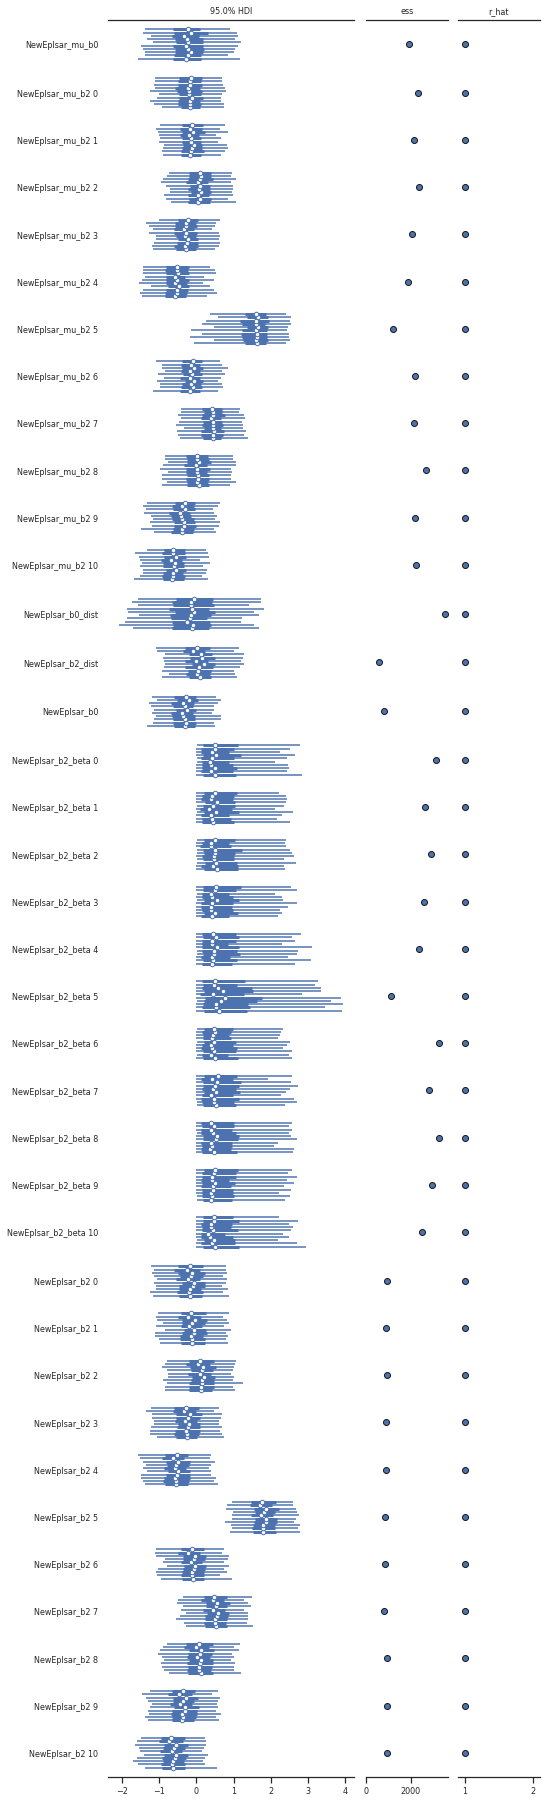

In [44]:
az.plot_forest(dataTrace_new_epLsar,var_names=['b0','b2'],filter_vars='like',figsize=(widthInch,5*heigthInch),hdi_prob=0.95,ess=True,r_hat=True);
if writeOut:
    plt.savefig(outPathPlots + "posterior_forest_{}.pdf".format('NewEplsar'),dpi=dpi)

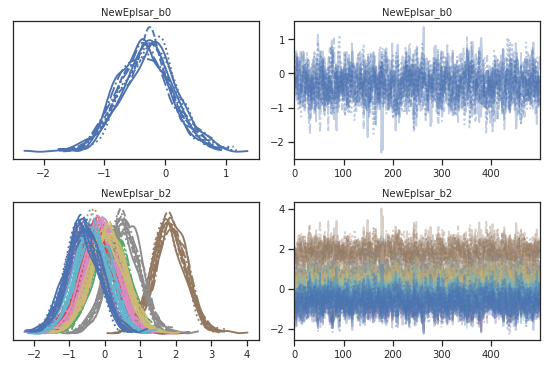

In [45]:
with new_epLsarModel as model:
    plotting_lib.plotTracesB(widthInch,heigthInch,dpi,writeOut,outPathPlots,trace_new_epLsar,'NewEplsar')

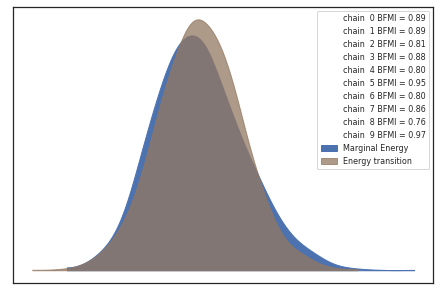

In [46]:
with new_epLsarModel as model:
    plotting_lib.pm.energyplot(trace_new_epLsar)

#### Posterior predictive distribution

In [47]:
with new_epLsarModel as model:
    posterior_pred_new_epLsar = pm.sample_posterior_predictive(trace_new_epLsar,samples=numPredSamples,random_seed=random_seed)

/home/bob/.local/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


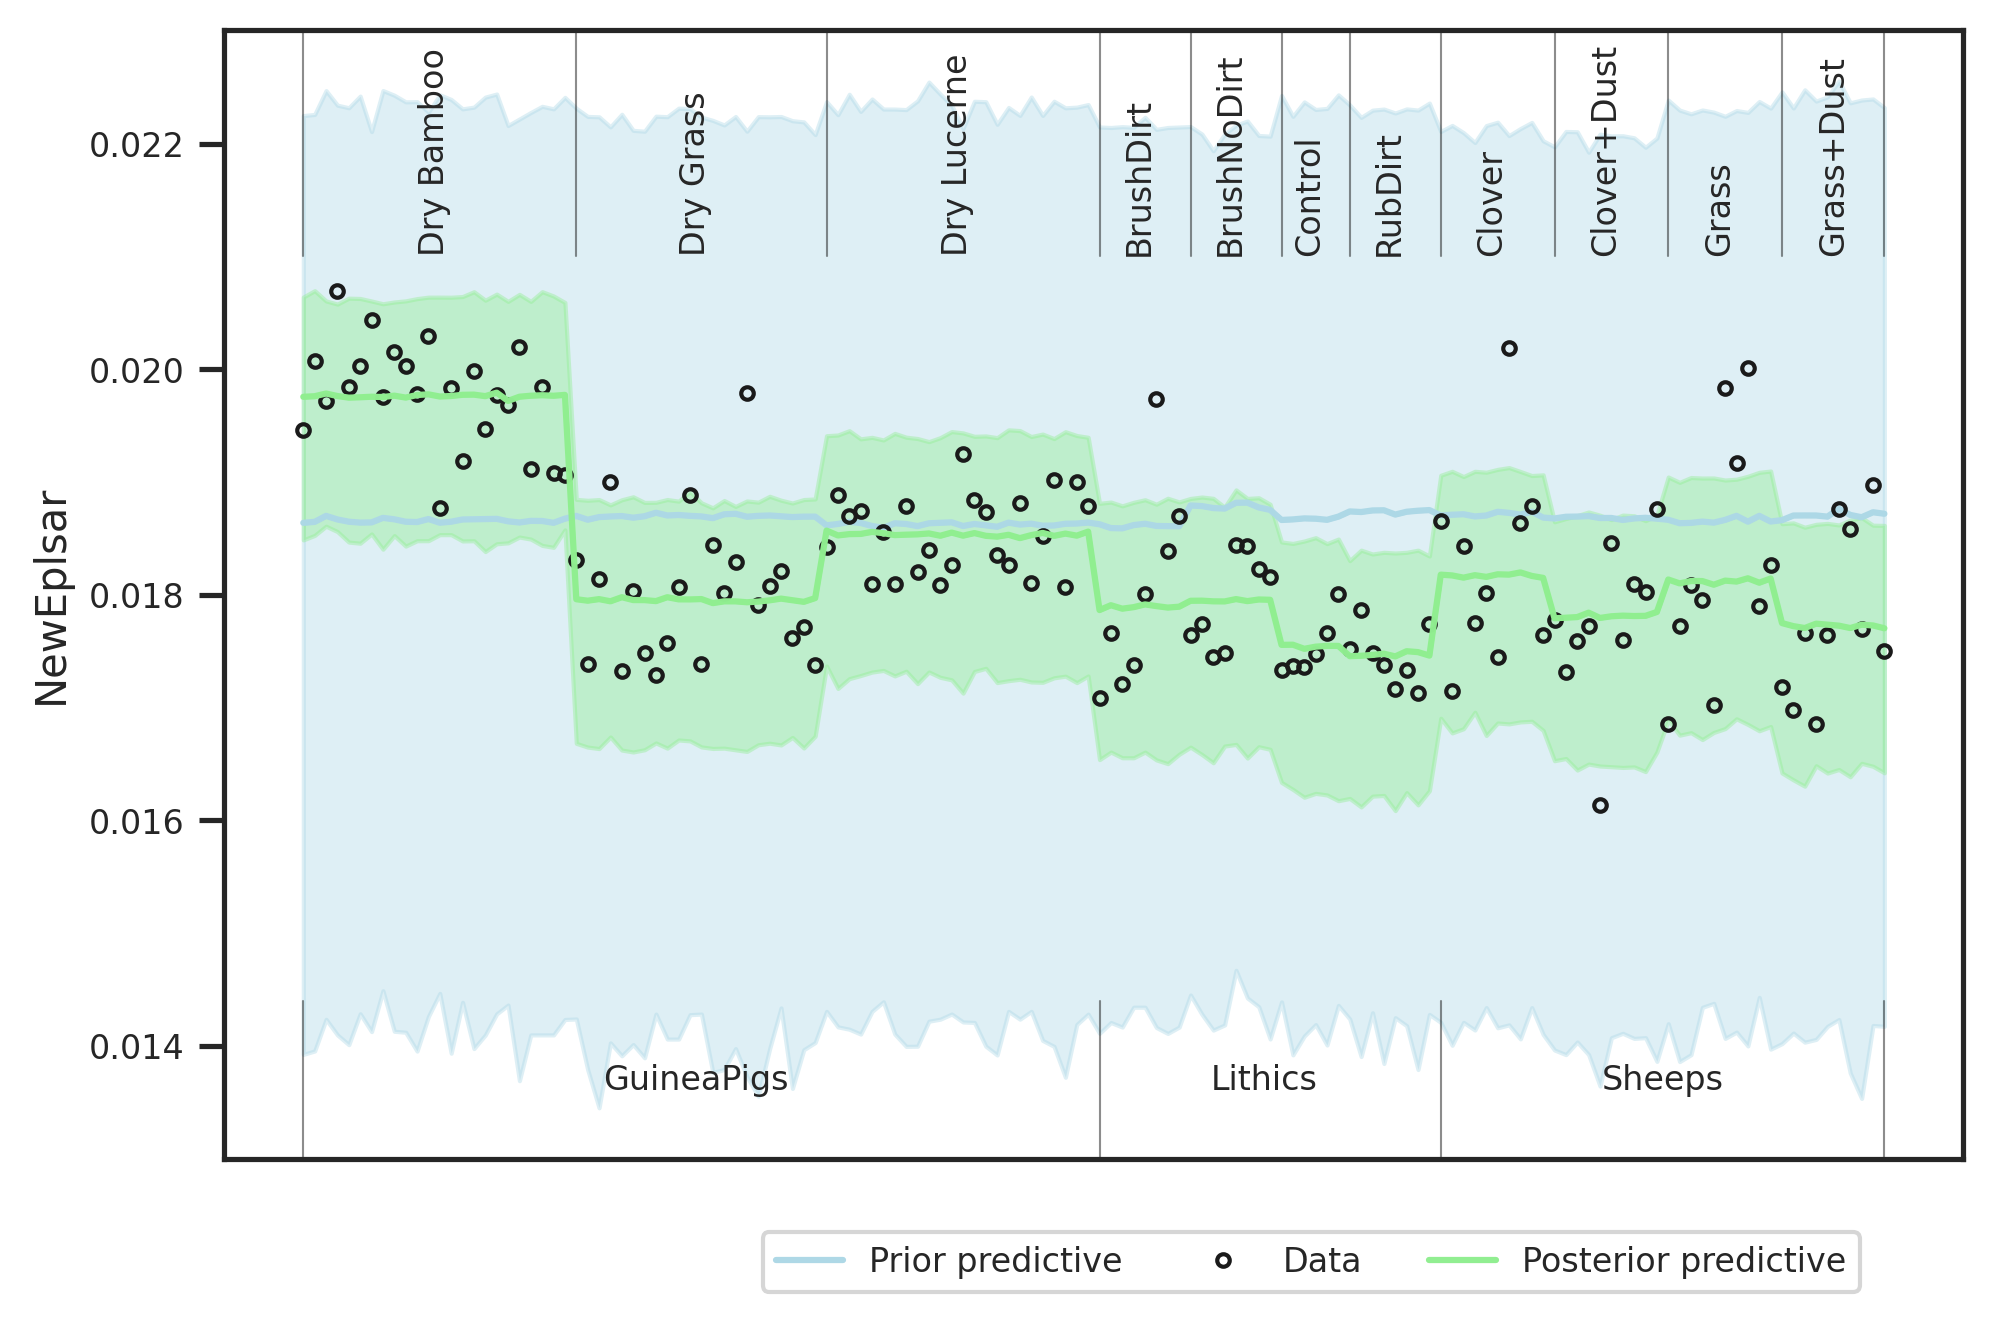

In [48]:
plotting_lib.plotPriorPosteriorPredictive(widthInch,heigthInch,dpi,writeOut,outPathPlots,dfNewAvail.reset_index(),dictMeanStd,prior_pred_new_epLsar,posterior_pred_new_epLsar,newZ,'NewEplsar')

### Posterior check

In [49]:
with new_epLsarModel as model:
    pm_data_new_epLsar = az.from_pymc3(trace=trace_new_epLsar,prior=prior_pred_new_epLsar,posterior_predictive=posterior_pred_new_epLsar)

arviz.data.io_pymc3 - WARNING - posterior predictive variable NewEplsar_y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


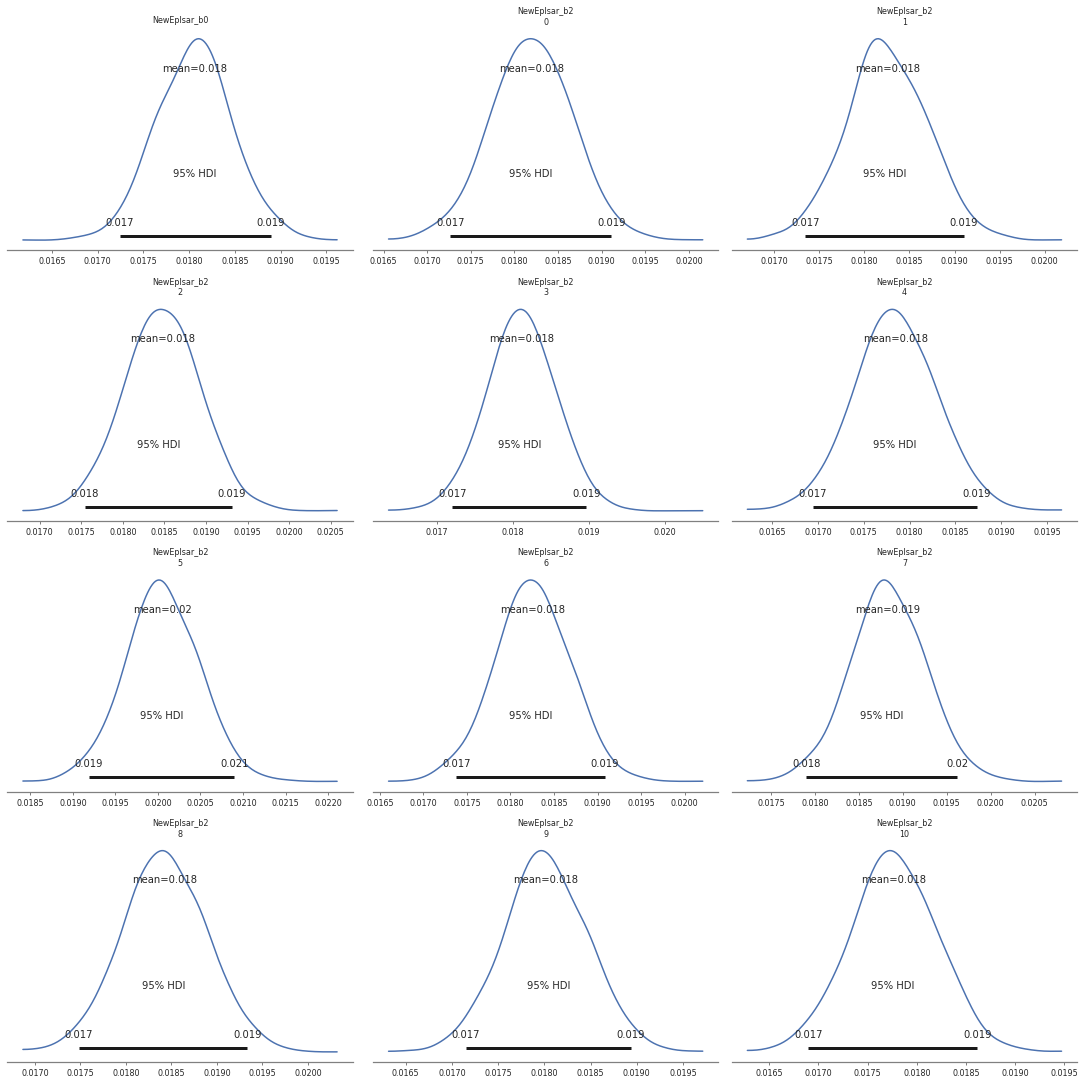

In [50]:
plotting_lib.plotPosterior(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd,pm_data_new_epLsar,'NewEplsar')

### Compare treatment differences with other epLsar values

In [51]:
b1P_Old = np.load("../derived_data/statistical_model_two_factors/epLsar_oldb1.npy")
b2P_Old = np.load("../derived_data/statistical_model_two_factors/epLsar_oldb2.npy")
M12P_Old = np.load("../derived_data/statistical_model_two_factors/epLsar_oldM12.npy")

In [52]:
from collections import defaultdict 

In [53]:
def plotTreatmentPosterior(widthInch,heigthInch,dpi,sizes,writeOut,path,dictMeanStd,dictTreatment,dictSoftware,trace,yname,x1,x3):
        
    SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = sizes
    
    mu_Val,sig_Val = dictMeanStd[yname]
    
    # get posterior samples    
    b2P = sig_Val*trace['{}_b2'.format(yname)]
    
    # prepare color dict for treatments
    # use groups of 4 colors, as in tab20c
    colorIndex = dict({5:0,6:1,7:2,0:4,1:5,4:6,10:7,2:8,3:9,8:10,9:11})
    
    # prepare dataset dict for treatments   
    dictDataset = dict({5:0,6:0,7:0,0:1,1:1,4:1,10:1,2:2,3:2,8:2,9:2})
    
    # === inverse dict ==== 
    inv_dictDataset = defaultdict(list)                                                                  
  
    # using loop to perform reverse mapping 
    for keys, vals in dictDataset.items():  
        for val in [vals]:  
            inv_dictDataset[val].append(keys) 
    # === 
    
    # get number of datasets    
    numDatasets = len(np.unique(list(dictDataset.values())))
    
    # get number of treatments per dataset
    dictDataset2NumberTreats = dict()
    for numDataset in range(numDatasets):        
        n = len(inv_dictDataset[numDataset])
        dictDataset2NumberTreats[numDataset] = n      
         
    # Get maximum of treatments per dataset
    tmax = np.max(list(dictDataset2NumberTreats.values()))
    
    
    # compute maximal number of pairs 
    maxpair = int(tmax*(tmax-1)/2)
    
    
    fig = plt.subplots(squeeze=False, figsize=(numDatasets*widthInch,maxpair*heigthInch), dpi=dpi);
    
    # store list for hdi
    hdiList = []

    for indexDataset in np.arange(numDatasets):
        # counter for row
        rowCounter = 0
        
        # first treatment 
        for treatmentNum_i,lvl2_i in enumerate(inv_dictDataset[indexDataset]):
            
            # second treatment 
            for treatmentNum_j,lvl2_j in enumerate(inv_dictDataset[indexDataset]):
                
                if treatmentNum_i > treatmentNum_j:
                                       
                    
                    # set subplot                    
                    curr_ax = plt.subplot2grid((maxpair, numDatasets), (rowCounter,indexDataset))
  
                    # compute difference between treatments for each software
                    diffS0 = sig_Val*((M12P_Old[:,0,lvl2_i]+b2P_Old[:,lvl2_i]) -(M12P_Old[:,0,lvl2_j]+b2P_Old[:,lvl2_j]))
                    diffS1 = sig_Val*((M12P_Old[:,1,lvl2_i]+b2P_Old[:,lvl2_i]) -(M12P_Old[:,1,lvl2_j]+b2P_Old[:,lvl2_j]))
                    
                    #plot posterior                    
                    sns.kdeplot(diffS1,ax=curr_ax,label="epLsar on {}".format(dictSoftware[1]),color='gray',alpha=0.3,ls='--');
                    sns.kdeplot(diffS0,ax=curr_ax,label="epLsar on {}".format(dictSoftware[0]),color='gray',alpha=0.3,ls='dotted');                    
                    sns.kdeplot(b2P[:,lvl2_i]-b2P[:,lvl2_j],ax=curr_ax,label="NewEplsar on {}".format(dictSoftware[0]),color='C0',alpha=0.3,ls='dotted');
                                        
                    # plot reference value zero
                    curr_ax.axvline(x=0,color="C1")
                    
                    # get hdi
                    hdi_new = az.hdi(az.convert_to_inference_data(b2P[:,lvl2_i]-b2P[:,lvl2_j]),hdi_prob=0.95)['x'].values
                    hdiS0 = az.hdi(az.convert_to_inference_data(diffS0),hdi_prob=0.95)['x'].values
                    hdiS1 = az.hdi(az.convert_to_inference_data(diffS1),hdi_prob=0.95)['x'].values  
                    
                    isSignificant = lambda x: (x[0] > 0.0) or (x[1] < 0.0)
                    
                    # store hdi
                    hdiList.append([dictTreatment[lvl2_i],dictTreatment[lvl2_j],
                                    hdi_new[0],hdi_new[1],isSignificant(hdi_new),                                 
                                   hdiS0[0],hdiS0[1],isSignificant(hdiS0),
                                    hdiS1[0],hdiS1[1],isSignificant(hdiS1)
                                   ])
                    
                    # set title 
                    nameFirst = dictTreatment[lvl2_i]
                    nameSecond = dictTreatment[lvl2_j]
                    title = "{} vs. {}".format(nameFirst,nameSecond)
                    if isSignificant(hdi_new):
                        title += ": Significant on NewEplsar"

                            
                    curr_ax.set_title(title)
                    
                    # add legend
                    curr_ax.legend()   
                    
                    # set x label
                    curr_ax.set_xlabel('Delta')
                    
                    # remove y label decoration
                    curr_ax.tick_params(left=False)
                    curr_ax.set(yticklabels=[])
                    
                    
                    # increment counter
                    rowCounter += 1
                    
    #plt.suptitle('Estimated differences between treatments on {}'.format(yname))
    
    plt.tight_layout()                
    
    if writeOut:
        plt.savefig(path + "treatment_pairs_{}.pdf".format(yname),dpi=dpi)
    
    plt.show()
    
    # convert hdi to df
    df = pd.DataFrame(hdiList,columns=["Treatment_i","Treatment_j",
                                       "hdi_NewEplsar_2.5%","hdi_NewEplsar_97.5%","isSignificant_NewEplsar","hdi_{}_2.5%".format(dictSoftware[0]),"hdi_{}_97.5%".format(dictSoftware[0]),"isSignificant_on_{}".format(dictSoftware[0]),
                                  "hdi_{}_2.5%".format(dictSoftware[1]),"hdi_{}_97.5%".format(dictSoftware[1]),"isSignificant_on_{}".format(dictSoftware[1])])
    return df

In [54]:
dfHDI = plotTreatmentPosterior(widthInch,heigthInch,dpi,sizes,writeOut,outPathPlots,dictMeanStd,dictTreatment,dictSoftware,trace_new_epLsar,'NewEplsar',x1[newIndex],x2[newIndex])

In [55]:
dfHDI

Treatment_i  Treatment_j  hdi_NewEplsar_2.5%  hdi_NewEplsar_97.5%  \
0     Dry Grass   Dry Bamboo           -0.002142            -0.001471   
1   Dry Lucerne   Dry Bamboo           -0.001520            -0.000917   
2   Dry Lucerne    Dry Grass            0.000239             0.000892   
3   BrushNoDirt    BrushDirt           -0.000522             0.000663   
4       Control    BrushDirt           -0.000967             0.000241   
5       Control  BrushNoDirt           -0.000965             0.000131   
6       RubDirt    BrushDirt           -0.001011             0.000149   
7       RubDirt  BrushNoDirt           -0.000979             0.000024   
8       RubDirt      Control           -0.000593             0.000470   
9   Clover+Dust       Clover           -0.000912             0.000170   
10        Grass       Clover           -0.000695             0.000519   
11        Grass  Clover+Dust           -0.000258             0.000920   
12   Grass+Dust       Clover           -0.001025             0.000078   
13   Grass+Dust  Clover+Dust           -0.000643             0.000438   
14   Grass+Dust        Grass           -0.000993             0.000166   

    isSignificant_NewEplsar  hdi_ConfoMap_2.5%  hdi_ConfoMap_97.5%  \
0                      True          -0.002002           -0.001351   
1                      True          -0.001620           -0.000971   
2                      True           0.000106            0.000752   
3                     False          -0.000651            0.000496   
4                     False          -0.001048            0.000116   
5                     False          -0.000850            0.000188   
6                     False          -0.000843            0.000264   
7                     False          -0.000702            0.000303   
8                     False          -0.000347            0.000679   
9                     False          -0.000529            0.000561   
10                    False          -0.000095            0.001442   
11                    False          -0.000065            0.001494   
12                    False           0.000259            0.001605   
13                    False           0.000257            0.001669   
14                    False          -0.000617            0.001148   

    isSignificant_on_ConfoMap  hdi_Toothfrax_2.5%  hdi_Toothfrax_97.5%  \
0                        True           -0.001957            -0.001303   
1                        True           -0.001706            -0.001088   
2                        True           -0.000082             0.000555   
3                       False           -0.000745             0.000278   
4                       False           -0.000962             0.000105   
5                       False           -0.000681             0.000328   
6                       False           -0.000676             0.000359   
7                       False           -0.000446             0.000526   
8                       False           -0.000276             0.000733   
9                       False           -0.000377             0.000802   
10                      False            0.000136             0.001852   
11                      False           -0.000046             0.001692   
12                       True            0.000421             0.001720   
13                       True            0.000231             0.001516   
14                      False           -0.000891             0.000924   

    isSignificant_on_Toothfrax  
0                         True  
1                         True  
2                        False  
3                        False  
4                        False  
5                        False  
6                        False  
7                        False  
8                        False  
9                        False  
10                        True  
11                       False  
12                        True  
13                        True  
14                       False

In [56]:
if writeOut:
    dfHDI.to_csv(outPathData+ 'hdi_{}.csv'.format('NewEplsar'))

## Summary<a name="summary"></a>

Show where NewEplsar yields other results then epLsar: 

In [62]:
dfHDI[(dfHDI.isSignificant_NewEplsar != dfHDI.isSignificant_on_ConfoMap) | (dfHDI.isSignificant_NewEplsar != dfHDI.isSignificant_on_Toothfrax) ][["Treatment_i","Treatment_j","isSignificant_NewEplsar","isSignificant_on_Toothfrax","isSignificant_on_ConfoMap","hdi_NewEplsar_2.5%","hdi_NewEplsar_97.5%","hdi_ConfoMap_2.5%","hdi_ConfoMap_97.5%","hdi_Toothfrax_2.5%","hdi_Toothfrax_97.5%"]]

Treatment_i  Treatment_j  isSignificant_NewEplsar  \
2   Dry Lucerne    Dry Grass                     True   
10        Grass       Clover                    False   
12   Grass+Dust       Clover                    False   
13   Grass+Dust  Clover+Dust                    False   

    isSignificant_on_Toothfrax  isSignificant_on_ConfoMap  hdi_NewEplsar_2.5%  \
2                        False                       True            0.000239   
10                        True                      False           -0.000695   
12                        True                       True           -0.001025   
13                        True                       True           -0.000643   

    hdi_NewEplsar_97.5%  hdi_ConfoMap_2.5%  hdi_ConfoMap_97.5%  \
2              0.000892           0.000106            0.000752   
10             0.000519          -0.000095            0.001442   
12             0.000078           0.000259            0.001605   
13             0.000438           0.000257            0.001669   

    hdi_Toothfrax_2.5%  hdi_Toothfrax_97.5%  
2            -0.000082             0.000555  
10            0.000136             0.001852  
12            0.000421             0.001720  
13            0.000231             0.001516

### Write out

In [63]:
!jupyter nbconvert --to html Statistical_Model_NewEplsar.ipynb

[NbConvertApp] Converting notebook Statistical_Model_NewEplsar.ipynb to html
[NbConvertApp] Writing 4926172 bytes to Statistical_Model_NewEplsar.html


In [64]:
!jupyter nbconvert --to markdown Statistical_Model_NewEplsar.ipynb

[NbConvertApp] Converting notebook Statistical_Model_NewEplsar.ipynb to markdown
[NbConvertApp] Support files will be in Statistical_Model_NewEplsar_files/
[NbConvertApp] Making directory Statistical_Model_NewEplsar_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_files
[NbConvertApp] Making directory Statistical_Model_Ne